In [86]:
import pandas as pd
import numpy as np
import requests as req
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

import boto3
import io
# Initialize S3 client, location of files for this project
s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

s3_bucket = "wri-public-data"
s3_folder = "resourcewatch/blog_data/GHG-GDP_Divergence_D3/"

RAW_DATA = s3_folder + "Raw_Data/"
PROCESSED_DATA = s3_folder + "Processed_Data/"
FINAL_DATA = s3_folder + "Final_Data/"
CONVERSIONS = s3_folder + "Conversions/"

# Functions for reading and uploading data to/from S3
def read_from_S3(bucket, key, index_col=0):
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    df = pd.read_csv(io.BytesIO(obj['Body'].read()), index_col=[index_col], encoding="utf8")
    return(df)

def write_to_S3(df, bucket, key):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer)
    s3_resource.Object(bucket, key).put(Body=csv_buffer.getvalue())

In [14]:
wb_name_to_iso3_conversion = read_from_S3(s3_bucket, CONVERSIONS+"World Bank to ISO3 name conversion.csv")

def add_iso(name):
    try:
        return(wb_name_to_iso3_conversion.loc[name,"ISO"])
    except:
        return(None)

In [11]:
indicators = {
     'EG.ELC.ACCS.ZS': 'Access to electricity (% of population)',
     'EG.FEC.RNEW.ZS': 'Renewable energy consumption (% of total final energy consumption)',
     'IT.NET.USER.ZS': 'Individuals using the Internet (% of population)',
     'NE.CON.PRVT.PC.KD': 'Household final consumption expenditure per capita (constant 2010 US$)',
     'NV.IND.TOTL.KD': 'Industry, value added (constant 2010 US$)',
     'NY.GDP.TOTL.RT.ZS': 'Total natural resources rents (% of GDP)',
     'SG.GEN.PARL.ZS': 'Proportion of seats held by women in national parliaments (%)',
     'SL.EMP.TOTL.SP.ZS': 'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
     'SM.POP.NETM': 'Net migration',
     'SP.DYN.LE00.IN': 'Life expectancy at birth, total (years)',
     'SP.URB.TOTL.IN.ZS': 'Urban population (% of total)',
     'TM.VAL.MRCH.CD.WT': 'Merchandise imports (current US$)'
}

In [24]:
all_world_bank_data = pd.DataFrame()
for indicator, series_name in indicators.items():
    # Results are paginated
    print(indicator)
    res = req.get("http://api.worldbank.org/countries/all/indicators/{}?date=1999:2016&format=json&per_page=10000".format(indicator))
    data = pd.io.json.json_normalize(res.json()[1])
    data = data[["country.value", "date", "value"]]
    data.columns = ["Country Name", "Year", "value"]
    data.set_index('Country Name', inplace=True)
    data["ISO"] = list(map(add_iso, data.index))
    data = data.loc[pd.notnull(data["ISO"])]    
    data["Indicator"] = series_name
    all_world_bank_data = all_world_bank_data.append(data)

EG.ELC.ACCS.ZS
EG.FEC.RNEW.ZS
IT.NET.USER.ZS
NE.CON.PRVT.PC.KD
NV.IND.TOTL.KD
NY.GDP.TOTL.RT.ZS
SG.GEN.PARL.ZS
SL.EMP.TOTL.SP.ZS
SM.POP.NETM
SP.DYN.LE00.IN
SP.URB.TOTL.IN.ZS
TM.VAL.MRCH.CD.WT


In [44]:
all_world_bank_data.head(10)

,Year,value,Indicator,ISO
Country Name,,,,
European Union,2016,None,Access to electricity (% of population),EUN
European Union,2015,None,Access to electricity (% of population),EUN
European Union,2014,100,Access to electricity (% of population),EUN
European Union,2013,100,Access to electricity (% of population),EUN
European Union,2012,100,Access to electricity (% of population),EUN
European Union,2011,100,Access to electricity (% of population),EUN
European Union,2010,100,Access to electricity (% of population),EUN
European Union,2009,100,Access to electricity (% of population),EUN
European Union,2008,100,Access to electricity (% of population),EUN


In [100]:
def run_linear_regressions(data, year):
    '''
    Inputs: world_bank data in long form
    Outputs: square matrix of regression coefficients for each indicator
    '''
    
    all_indicators = data["Indicator"].unique()
    num_indicators = len(all_indicators)
    # Result will be an upper right triangular square matrix
    regression_results = np.zeros((num_indicators, num_indicators))
    
    for ix_x in range(num_indicators):
        for ix_y in range(ix_x+1):
            
            # Extract data
            # TO DO: allow for year ranges
            ind_x = all_indicators[ix_x]
            ind_y = all_indicators[ix_y]
            print("regressing {} against {}".format(ind_x, ind_y))
            
            data_x = data.loc[(data['Indicator']==ind_x) & (data['Year']==year), 'value']
            data_y = data.loc[(data['Indicator']==ind_y) & (data['Year']==year), 'value']
            
            # Clean data to eliminate NaNs from both data_x and data_y
            all_ids = list(data_x.index) + list(data_y.index)
            
            data_x_null_ids = list(data_x[pd.isnull(data_x)].index)
            data_y_null_ids = list(data_y[pd.isnull(data_y)].index)
            remove_ids = data_x_null_ids + data_y_null_ids
            
            data_x = data_x.drop(remove_ids)
            data_y = data_y.drop(remove_ids)

            data_x = data_x.values.reshape(-1, 1)
            data_y = data_y.values.reshape(-1, 1)
            assert(data_x.shape[0] == data_y.shape[0])
            
            if data_x.shape[0] > 0:
                # Run regression
                lm = linear_model.LinearRegression() 
                lm.fit(data_x, data_y)

                # Extract coefficient of determination (r^2)
                r_squared = lm.score(data_x, data_y)

                # Store results
                regression_results[ix_y, ix_x] = r_squared
            else:
                regression_results[ix_y, ix_x] = None
    
    return regression_results

In [101]:
regression_results = run_linear_regressions(all_world_bank_data, '2005')

regressing Access to electricity (% of population) against Access to electricity (% of population)
regressing Renewable energy consumption (% of total final energy consumption) against Access to electricity (% of population)
regressing Renewable energy consumption (% of total final energy consumption) against Renewable energy consumption (% of total final energy consumption)
regressing Individuals using the Internet (% of population) against Access to electricity (% of population)
regressing Individuals using the Internet (% of population) against Renewable energy consumption (% of total final energy consumption)
regressing Individuals using the Internet (% of population) against Individuals using the Internet (% of population)
regressing Household final consumption expenditure per capita (constant 2010 US$) against Access to electricity (% of population)
regressing Household final consumption expenditure per capita (constant 2010 US$) against Renewable energy consumption (% of total f

In [102]:
regression_results

array([[  1.00000000e+00,   6.67189288e-01,   3.28915512e-01,
          2.53023519e-01,   4.25667455e-03,   3.85168820e-02,
          1.13470806e-02,   1.61437276e-01,              nan,
          7.37101976e-01,   4.31229123e-01,   5.27674604e-03],
       [  0.00000000e+00,   1.00000000e+00,   2.05049052e-01,
          2.13460970e-01,   9.24496892e-03,   3.69471154e-03,
          3.62805506e-04,   2.23345400e-01,              nan,
          5.23124112e-01,   3.41758297e-01,   9.37431638e-03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          7.44508001e-01,   5.44981141e-03,   9.94389993e-02,
          1.93697458e-01,   4.44884746e-03,              nan,
          4.64125576e-01,   3.65489335e-01,   1.14866808e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   7.36731057e-03,   5.74398196e-02,
          1.15099541e-01,   6.73552790e-04,              nan,
          4.14855756e-01,   3.93452201e-01,   1.20814154e-02],
    

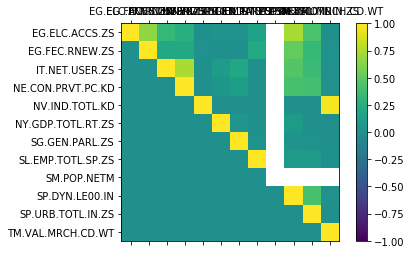

In [103]:
# https://machinelearningmastery.com/visualize-machine-learning-data-python-pandas/
fig = plt.figure()
ax = fig.add_subplot(111)
names = list(indicators.keys())
cax = ax.matshow(regression_results, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()